In [289]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [290]:
x_data = np.float64(np.linspace(-15, 15, 600))
y_data = np.float64(np.sin(x_data) / x_data)

In [291]:
dataset = Dataset(x_data, y_data)
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

activation = nn.Sigmoid()

In [292]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(1, 30, 1)

In [293]:
for i, (x, y) in enumerate(trainloader):
    V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ x.reshape(1, -1))
    H = torch.concatenate([torch.ones(1, len(x)), V], dim=0).T
    Y = y.reshape(1, -1).T
    if i == 0:
        # W2 = torch.linalg.pinv(H) @ Y.reshape(1, -1, 1)
        P = torch.linalg.inv(H.T @ H + 1e-8*torch.eye(H.shape[1]))
        W2 = P @ H.T @ Y.reshape(1, -1, 1)
    else:
        P = P - P @ H.T @ torch.linalg.inv(torch.eye(H.shape[0]) + H @ P @ H.T) @ H @ P
        W2 = W2 + P @ H.T @ (Y.reshape(1, -1, 1) - H @ W2)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

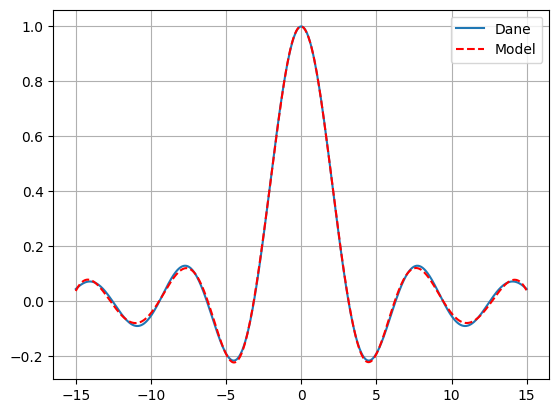

Train error: 4.222752431104033e-05
Test error: 4.9602076257420135e-05


In [294]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')